### Setup

In [107]:
!pip install -Uqq diffusers ftfy accelerate matplotlib wandb pandas scipy

In [2]:
!pip install -Uqq git+https://github.com/huggingface/transformers

In [1]:
import torch
import requests
from io import BytesIO
from PIL import Image
from matplotlib import pyplot as plt
from diffusers import (StableDiffusionPipeline,
                       StableDiffusionImg2ImgPipeline,
                       StableDiffusionInpaintPipeline,
                       StableDiffusionDepth2ImgPipeline)

import pandas as pd

def download_image(url: str):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert('RGB')

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((256, 256))
mask_image = download_image(mask_url).resize((256, 256))

device = ('mps' if torch.backends.mps.is_available()
          else 'cuda' if torch.cuda.is_available()
          else 'cpu')

seed = 42

### Generating images from text

In [2]:
model_name = 'stabilityai/stable-diffusion-2-1-base'
pipeline = StableDiffusionPipeline.from_pretrained(model_name).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/transformers/models/clip/feature_extraction_clip.py:31: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  FutureWarning,


  0%|          | 0/40 [00:00<?, ?it/s]

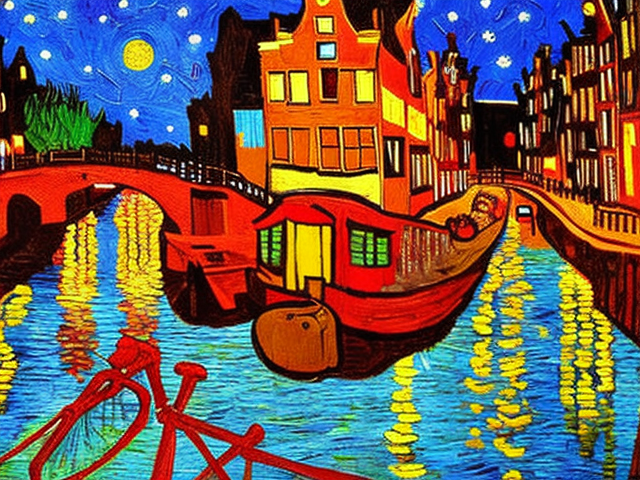

In [3]:
generator = torch.Generator(device=device).manual_seed(seed)

images = pipeline(
    prompt='Amsterdam Red Light District at night painting in the style of Van Gogh',
    negative_prompt='Low quality, blurry',
    height=480,
    width=640,
    guidance_scale=8,
    num_inference_steps=40,
    generator=generator).images

display(images[0])

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

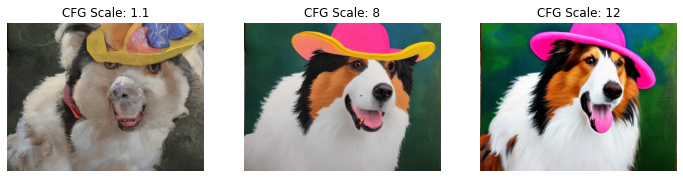

In [4]:
cfg_scales = [1.1, 8, 12]
prompt = 'A collie with a pink hat'
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(12, 5))

for i, ax in enumerate(axs):
    generator = torch.Generator(device=device).manual_seed(seed)
    
    image = pipeline(
        prompt=prompt,
        height=480,
        width=640,
        guidance_scale=cfg_scales[i],
        num_inference_steps=35,
        generator=generator
    ).images[0]

    ax.imshow(image)
    ax.set_title(f'CFG Scale: {cfg_scales[i]}')
    ax.set_axis_off()
    
plt.show()

### Pipeline components

In [5]:
print(list(pipeline.components.keys()))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


In [6]:
images = torch.rand(1, 3, 512, 512).to(device)
print(images.shape)

with torch.inference_mode():
    latents = pipeline.vae.encode(images).latent_dist.mean * 0.18215
print(latents.shape)

with torch.inference_mode():
    decoded_images = pipeline.vae.decode(latents / 0.18215).sample
print(decoded_images.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 4, 64, 64])
torch.Size([1, 3, 512, 512])


### The tokenizer and Text Encoder

In [7]:
prompt = 'A painting of a flooble'
input_ids = pipeline.tokenizer([prompt]).input_ids
tokens = [pipeline.tokenizer.decode(input_id) for input_id in input_ids[0]]

with torch.inference_mode():
    text_embeds = pipeline.text_encoder(torch.tensor(input_ids).to(device)).last_hidden_state
    
display(
    pd.DataFrame({'input_id': input_ids[0],
                  'token': tokens}).T
)

print(f'text embeddings shape: {text_embeds.shape}')

,0,1,2,3,4,5,6,7
input_id,49406,320,3086,539,320,4062,1059,49407
token,<|startoftext|>,a,painting,of,a,floo,ble,<|endoftext|>


text embeddings shape: torch.Size([1, 8, 1024])


In [8]:
# final "final" text embeddings
text_embeds = pipeline._encode_prompt(prompt=prompt,
                                      device=device,
                                      num_images_per_prompt=1,
                                      do_classifier_free_guidance=False,
                                      negative_prompt=None)
text_embeds.shape

torch.Size([1, 77, 1024])

### The UNet

In [9]:
timestep = pipeline.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeds = torch.randn(1, 77, 1024).to(device)

with torch.inference_mode():
    noise_pred = pipeline.unet(sample=latents, timestep=timestep, encoder_hidden_states=text_embeds).sample

print(noise_pred.shape)

torch.Size([1, 4, 64, 64])


### The Scheduler

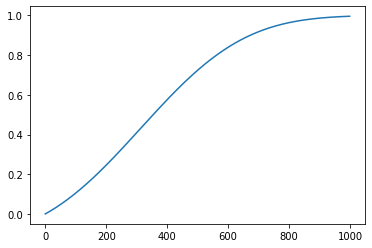

In [10]:
plt.plot(abs(pipeline.scheduler.alphas_cumprod-1))
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

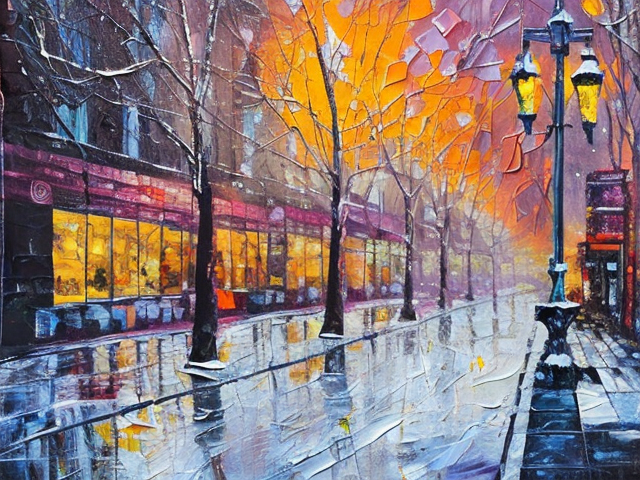

In [11]:
from diffusers import LMSDiscreteScheduler

pipeline.scheduler = LMSDiscreteScheduler.from_config(pipeline.scheduler.config)

images = pipeline(
    prompt='Palette knife painting of a winter cityscape',
    height=480,
    width=640,
    generator=torch.Generator(device=device).manual_seed(seed)
).images

display(images[0])

### A DIY Sampling loop

In [16]:
guidance_scale = 8
num_inference_steps = 30
prompt = 'Beautiful picture of a wave breaking'
negative_prompt = 'zoomed in, blurry, oversaturated, warped'
generator = torch.Generator(device=device).manual_seed(seed)

# text embedding
text_embeds = pipeline._encode_prompt(prompt=prompt,
                                      device=device,
                                      num_images_per_prompt=1,
                                      do_classifier_free_guidance=True,
                                      negative_prompt=negative_prompt)
# image embedding
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipeline.scheduler.init_noise_sigma

# scheduler's timesteps
pipeline.scheduler.set_timesteps(num_inference_steps=num_inference_steps, device=device)

In [22]:
print(latents.shape)
print(torch.cat([latents] * 2).shape)
print(latents.expand(2, *latents.shape[1:]).shape)

torch.Size([1, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


In [30]:
latents2 = torch.cat([latents] * 2)
latents2_scaled = pipeline.scheduler.scale_model_input(latents2, pipeline.scheduler.timesteps[0])

with torch.inference_mode():
    noise_pred = pipeline.unet(latents2_scaled, pipeline.scheduler.timesteps[0], text_embeds).sample
    
noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
noise_pred_uncond.shape, noise_pred_text.shape

(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

In [28]:
noise_pred.shape

torch.Size([2, 4, 64, 64])